# S.a.M: Music Recommender Feature


Hello! In this notebook we will be implementing the music recommendation system for our AI: S.a.M. S.a.M allows the user to input their favorite song and get recommendations based off of it. This will be possible with the help of K-Means clustering and Content-based filtering.

Let's begin!


## Step 1: Loading the data

In order to start, we will have to import the necessary libraries and resources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


The dataset we will be using is called, "Spotify Tracks Dataset" and was taken from the website [Kaggle](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset). We will now read the CSV file containing our dataset and put it in a pandas dataframe. In dataframe format, we will able to show important information such as the format of the dataset and its shape.

In [2]:
songs_df = pd.read_csv('dataset.csv', index_col=0) #index_col=0 used to removed any unnamed columns which our dataset had one
songs_df.head(10) #the head() function usually prints out the first 5 rows of the dataset but we will show the first 10

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [3]:
print("The dimensions of our dataset are:", songs_df.shape)

The dimensions of our dataset are: (114000, 20)


As seen above, our dataset consists of 114,000 songs with 20 features. These features consists of basic information of the song such as track name, artist, and album. But, it also has more interesting features that might be useful for use such as, loudness, acousticness, tempo, and genre. These can be useful when it comes to creating clusters.

## Step 2: Cleaning the Data

Before implementing clusters, we first need to clean our data of unnecessary columns. Clustering works best if we keep features that are numerical values. This will make it so our recommendation systems recommends based on similar sound. To achieve this, we will drop columns that do not contain numerical data.

In [4]:
songs_df.dropna(inplace=True) #we will first drop any NaN values for efficiency
songs_df.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


After going through the dataset, we found that there were many duplicate songs. This will affect our calculations later down the line so it will best to drop duplicate songs right now. We will be deleting entries that contain the same track name and artist(s) in the dataset.

In [5]:
songs_df.drop_duplicates(subset=['artists', 'track_name'], inplace=True) #drops any occurence after the first that shares same song name and artist name
songs_df.reset_index(drop=True, inplace=True) #drop_duplicate does not reset index automatically

Now we have to manually drop any remaining uneccessary columns such as 'track_id', 'explicit', and 'track_genre'

In [6]:
dropped_df = songs_df.drop(['track_id', 'artists','album_name', 'track_name','explicit', 'track_genre'], axis=1)
dropped_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
5,58,214240,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4
6,74,229400,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3
7,80,242946,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4
8,74,189613,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4
9,56,205594,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4


In [7]:
print("New dimensions of dataset:", dropped_df.shape)

New dimensions of dataset: (81343, 14)


We have now reduced our dataset to 81,343 unqiue songs with 14 numerical features. Last step before implementing clusters is to normalize our data. If we did not do that, our graph would be skewed to favored larger values such as duration.

In [8]:
normalized_df = dropped_df.copy() #copy created to preserve columns
normalized_df = StandardScaler().fit_transform(normalized_df) #normalizing through the standard scalar feature
normalized_df = pd.DataFrame(normalized_df, columns=dropped_df.columns) #gives our normalized dataframe the correct columns
normalized_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1.973599,-0.006425,0.656694,-0.672849,-1.204714,0.348353,-1.311471,0.463073,-0.875005,-0.557109,0.697416,0.955736,-1.136049,0.225753
1,1.047597,-0.702235,-0.783568,-1.813434,-1.204714,-1.628926,0.762503,-0.108831,1.748255,-0.557096,-0.598793,-0.745219,-1.482163,0.225753
2,1.150486,-0.176738,-0.682300,-1.067221,-1.485802,-0.214914,0.762503,-0.285460,-0.352001,-0.557112,-0.518095,-1.303345,-1.520565,0.225753
3,1.870710,-0.253078,-1.649976,-2.224818,-1.485802,-1.870219,0.762503,-0.451801,1.692365,-0.556899,-0.442441,-1.216019,1.978011,-1.965329
4,2.436600,-0.279518,0.330384,-0.742444,-0.923627,-0.204923,0.762503,-0.312041,0.409857,-0.557112,-0.690082,-1.124897,-0.072882,0.225753
5,1.201931,-0.147431,0.724206,-0.595522,0.200725,-0.040166,0.762503,0.137251,-0.119620,-0.557112,-0.154955,0.769694,-0.800822,0.225753
6,2.025044,-0.017293,-0.856706,-1.886896,-0.923627,-0.042993,0.762503,-0.458660,1.551172,-0.557104,-0.647716,-1.468505,0.635244,-1.965329
7,2.333711,0.098990,0.808596,-0.738578,1.606164,-0.138945,0.762503,-0.405500,0.674595,-0.557112,-0.617454,0.944345,0.956399,0.225753
8,2.025044,-0.358837,0.369767,-0.854570,-1.485802,-0.019995,0.762503,-0.446656,-0.104912,-0.557112,-0.346612,0.781084,0.263640,0.225753
9,1.099042,-0.221651,-0.659796,-0.011697,-1.204714,0.343829,0.762503,-0.510106,0.283371,-0.544476,-0.737492,-1.014790,-1.435364,0.225753


## Step 3: Implementing Principal Component Analysis

To make the clusters clearly visible, we will first reduce the dimensionality of our data so that the clustering is based off the most important features of the dataset. We will be doing this using Principal Component Analysis (PCA).
> PCA is a dimension reduction algorithm that reduces the dimensionality of a dataset while still maintaining crucial information. When combined with K-means clustering, it will lead to better defined clusters. Evidence of its effectiveness can be seen in [this paper](https://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf).

We begin by figuring out how many principal components we can reduce our data too. We do this by creating a PCA instance which will use as many components as the number of features in our data. We will then plot the cumulative explained variance ratio for each number of components.

In [9]:
pca = PCA()
pca_df = pca.fit_transform(normalized_df) #creates the principal components
pca.explained_variance_ratio_ #shows the explained variance ratio of each principal component

array([0.21318303, 0.11069396, 0.09423274, 0.08362969, 0.07550754,
       0.06812371, 0.06335437, 0.06261921, 0.05938178, 0.05492398,
       0.05012018, 0.03094987, 0.02331204, 0.0099679 ])

As seen above, we have 14 principal components since we have 14 features and each component has there own percentage of explained variance. We will plot the ratio and find at which number of components will we have explained variance ratio above 0.80. Plot inspired by: https://365datascience.com/tutorials/python-tutorials/pca-k-means/

Text(0, 0.5, 'Cumulative explained variance')

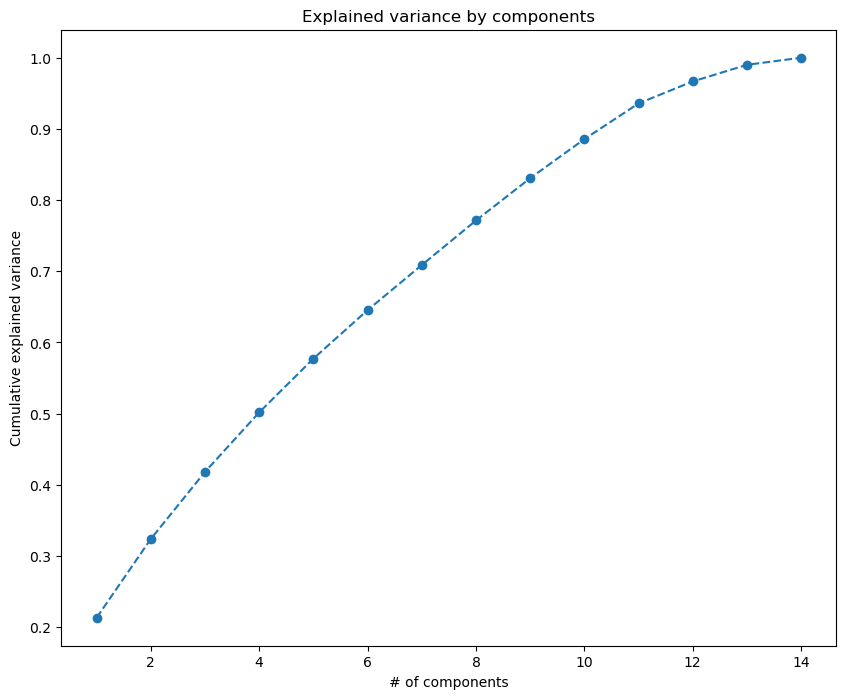

In [10]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(pca.explained_variance_ratio_.cumsum()) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')

According to our graph, at nine principal components, we will have a cumulative explained variance ratio above 0.80 which means that will be the number of components we will use.

In [11]:
pca = PCA(n_components=9)
pca_df = pca.fit_transform(normalized_df)
print(sum(pca.explained_variance_ratio_)) #to verify that nine is the right number

0.8307260347911329


## Step 4. Implementing K-means Clustering

### Step 4a. Elbow Method
For K-means clustering to work, we need to figure out the k number of clusters for our data. This is a number that has to be figured out by us. It is important to have the right amount of clusters as having too little clusters leads to underfitting and have too many clusters leads to overfitting.

To figure out how many clusters we will be using, we will be using the Elbow Method. This method involves creating a K-means clustering model with varying amounts of clusters, calculating the inertias of each and plotting it to see at which point do we see a elbow-like bend in the graph. So, we will be taking our Principal Component model and running it through the clustering algorithm to find the optimal amount of clusters. Method implemented with help from: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

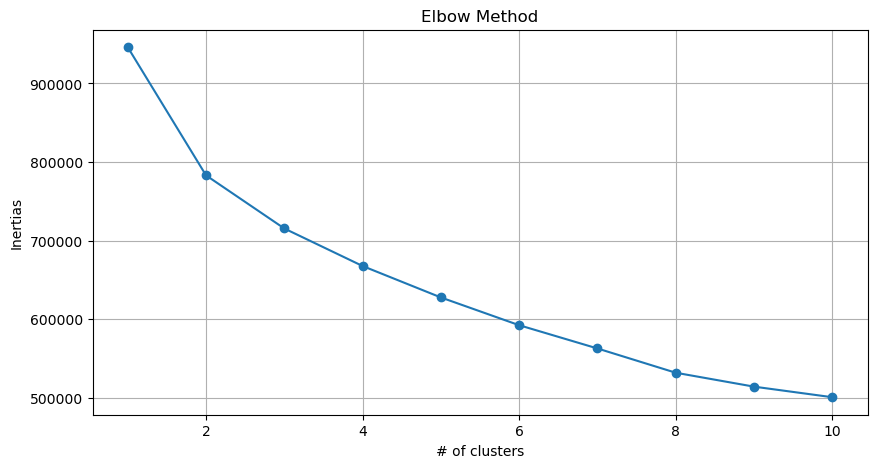

In [12]:
inertias = [] #store the sums of the squared distances of samples to their closest cluster center
clusters = [] #stores the number of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10) #creates a kmeans model ranging from 1 cluster to 10 clusters
    kmeans.fit(pca_df)
    clusters.append(i)
    inertias.append(kmeans.inertia_)
#graph the inertias
plt.figure(figsize=(10,5))
plt.plot(clusters, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel("# of clusters")
plt.ylabel("Inertias")
plt.grid(True)
plt.show()

We pick the point in which the inertia starts decreasing in a linear manner which appears to be point three. We will be forming a Kmeans model with 3 clusters and creating a column into our dataframes that assigns each song to their respective cluster.

In [13]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(pca_df)
songs_df['Cluster'] = kmeans.labels_ #assigns each song into their respective cluster
normalized_df['Cluster'] = kmeans.labels_ #does the same into our modified dataframe
songs_df.head(10) #to showcase cluster column

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,2
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,2
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,2
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,0
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,...,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,0
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,2
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,0
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,...,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,0
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,...,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,0


In [14]:
normalized_df.head(10) #to showcase cluster column

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,1.973599,-0.006425,0.656694,-0.672849,-1.204714,0.348353,-1.311471,0.463073,-0.875005,-0.557109,0.697416,0.955736,-1.136049,0.225753,0
1,1.047597,-0.702235,-0.783568,-1.813434,-1.204714,-1.628926,0.762503,-0.108831,1.748255,-0.557096,-0.598793,-0.745219,-1.482163,0.225753,2
2,1.150486,-0.176738,-0.682300,-1.067221,-1.485802,-0.214914,0.762503,-0.285460,-0.352001,-0.557112,-0.518095,-1.303345,-1.520565,0.225753,2
3,1.870710,-0.253078,-1.649976,-2.224818,-1.485802,-1.870219,0.762503,-0.451801,1.692365,-0.556899,-0.442441,-1.216019,1.978011,-1.965329,2
4,2.436600,-0.279518,0.330384,-0.742444,-0.923627,-0.204923,0.762503,-0.312041,0.409857,-0.557112,-0.690082,-1.124897,-0.072882,0.225753,0
5,1.201931,-0.147431,0.724206,-0.595522,0.200725,-0.040166,0.762503,0.137251,-0.119620,-0.557112,-0.154955,0.769694,-0.800822,0.225753,0
6,2.025044,-0.017293,-0.856706,-1.886896,-0.923627,-0.042993,0.762503,-0.458660,1.551172,-0.557104,-0.647716,-1.468505,0.635244,-1.965329,2
7,2.333711,0.098990,0.808596,-0.738578,1.606164,-0.138945,0.762503,-0.405500,0.674595,-0.557112,-0.617454,0.944345,0.956399,0.225753,0
8,2.025044,-0.358837,0.369767,-0.854570,-1.485802,-0.019995,0.762503,-0.446656,-0.104912,-0.557112,-0.346612,0.781084,0.263640,0.225753,0
9,1.099042,-0.221651,-0.659796,-0.011697,-1.204714,0.343829,0.762503,-0.510106,0.283371,-0.544476,-0.737492,-1.014790,-1.435364,0.225753,0


Now we will visualize our data. To do this well be plotting the first two principal components of our dataset while showing the cluster that each song is in. We will only be plotting two as it is not possible to plot nine components but two is enough to showcase our data. Graph inspired from: https://365datascience.com/tutorials/python-tutorials/pca-k-means/

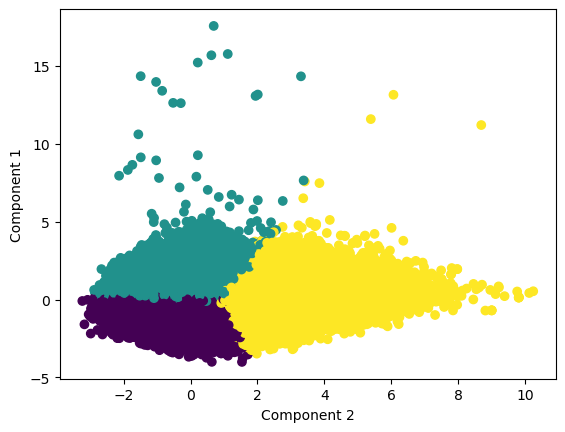

In [15]:
x_axis = normalized_df['pca_1'] = pca_df[:,0] #add principal component 1 into dataframe
y_axis = normalized_df['pca_2'] = pca_df[:,1] #add principal component 2 into dataframe
plt.scatter(x_axis, y_axis, c=normalized_df['Cluster']) #plots the two components and colors them according to cluster
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.show()

We have successfully clustered our songs! It is time to create our song recommending functions.

## Step 5. Create Song Recommender
With our songs clustered, to create our recommender we need a way to locate song the user inputs in our database, find the cluster number and recommend songs inside that cluster.

In [16]:
#find the index of the specified song in order to later find the cluster number
#takes in the song dataframe, track name, and artist name optionally
#artist name is optional to handle cases where multiple artists share the same song name
def get_Song_Index(df, track_name, artist=None):
    try:
        if artist:
            track_index = df[(df['track_name'] == track_name) & (df['artists'] == artist)].index[0]
        else:
            track_index = df[(df['track_name'] == track_name)].index[0]
        return track_index
    except IndexError:
        print("So sorry! It seems as if the song or artist(s) you are trying to search for is not available.")
        print("Either the song/artist(s) is not present in our database or the names were typed incorrectly.")
        print("Make sure to spell the song and artist(s) names exactly as they appears on Spotify and try again.")
        return None

In [17]:
#takes in the data frame with songs, the track name, and artist name optionally
def get_recommendations(df, track_name, artist=None):
    track_index = get_Song_Index(df, track_name, artist)
    print('You chose: ' + track_name + ' by ' + df.loc[track_index]['artists'])
    print('Here are your recommendations:')
    cluster = df.loc[track_index]['Cluster'] #finds the cluster of the inputted song
    filter = (df['Cluster'] == cluster)
    
    filtered_df = df[filter] #creates a dataframe with only songs of the indicated cluster
    for i in range(5):
        recommendation = filtered_df.sample()
        print(recommendation.iloc[0]['track_name'] + ' by ' + recommendation.iloc[0]['artists'])

In [18]:
get_recommendations(songs_df, 'Is This It', "The Strokes")

You chose: Is This It by The Strokes
Here are your recommendations:
Tenderness by Orlando Voorn
Quiérete by Brock Ansiolitiko
BEAUTIFUL MONSTER by STAYC
Give It To Me - Full Vocal Mix by Matt Sassari
By Your Side (feat. Tom Grennan) by Calvin Harris;Tom Grennan


Due to the vast nature of our clusters, some of the recommendations may seem outlandish and only vaguely similar. To improve our recommender, we will introduce euclidean distance calculations into our recommender. We will be measuring the distance between our inputted song and every other song in the cluster and recommend the songs with the shortest distance to our song. The calculation will be based off certain features to make sure that our songs will be as close as possible. We use euclidean distance instead of cosine similarity like in our music recommender as the magnitude of each feature is considered which cosine similarity does not taken into account magnitude.

In [19]:
#function takes in the features to compare, the song df, normalized df, track name and artist name optionally
#recommender automatically recommends 10 songs but could be changed
def get_recommendations_euclidean(features, df, normalized_df, track_name, artist=None, n_songs=10):
    
    track_index = get_Song_Index(df, track_name, artist)
    print('You chose: ' + track_name + ' by ' + df.loc[track_index]['artists'])
    print('Here are your recommendations:')
    
    track_cluster = normalized_df.loc[track_index]['Cluster'] #get the cluster number
    cluster = normalized_df[normalized_df['Cluster'] == track_cluster] #isolate the cluster into its own data frame
    cluster_df = cluster[features] #create new data frame that only shows the stated features 
    
    user_song = cluster_df.loc[track_index, features]
    user_song = user_song.to_frame().T #turns the user's song into a dataframe to be able to use function
    
    distances = euclidean_distances(user_song, cluster_df) #store the calculations into a matrix
    distances = distances.flatten() #converts distances into a 1D matrix
    sorted_indices = np.argsort(distances) #sorts the distances into ascending order
        
    most_similar_songs = cluster_df.iloc[sorted_indices[:n_songs + 1]] #gathers the most similar songs
    indices = most_similar_songs.index
    songs_in_df = df.loc[indices] #finds the songs in the original songs data frame
    
    for i in range(n_songs + 1):
        if songs_in_df.iloc[i]['track_name'] != track_name: #skips the user's inputted song which was included in the calculations
            print(songs_in_df.iloc[i]['track_name'] + ' by ' + songs_in_df.iloc[i]['artists'])
        

In [20]:
features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
           'instrumentalness', 'liveness', 'valence', 'tempo'] #the features we will be comparing
get_recommendations_euclidean(features, songs_df, normalized_df, 'Is This It', 'The Strokes')

You chose: Is This It by The Strokes
Here are your recommendations:
Maria Magdalena - Remastered by Sandra
Skiptracing by Mild High Club
Saudebazi (Encore) by Javed Ali
Écoute Chérie by Vendredi sur Mer
Sweet Jane - Full Length Version; 2015 Remaster by The Velvet Underground
Lakshya by Shankar-Ehsaan-Loy;Shankar Mahadevan
Kiri Ga Naikara by Fujii Kaze
Mean Mr Mustard - Remastered 2009 by The Beatles
Be Alright by 高爾宣 OSN
Indios y Vaqueros by Sinsinati;Álvaro De Luna


With that, the song curator feature of S.a.M is complete! To further test its capabilites, we will add a random song tester. Feel free to run it as many times as you'd like to see what songs get recommended.

In [21]:
def get_random_song(df):
    random_row = df.sample() #finds a random row
    track_name = random_row.iloc[0]['track_name'] #gets song name
    track_artists = random_row.iloc[0]['artists'] #gets artists
    return track_name, track_artists

In [23]:
random_track, artists = get_random_song(songs_df)
#print(random_track + " by " + artists) #used for testing purposes
get_recommendations_euclidean(features, songs_df, normalized_df, random_track, artists)

You chose: In the Midnight Hour by Wilson Pickett
Here are your recommendations:
Fever by Kylie Minogue
Wonderful World, Beautiful People by Jimmy Cliff
Merry Christmas, Baby [take 1] - Take 1 by Otis Redding
Tus Ojos by Belanova
Psycho Killer - 2005 Remaster by Talking Heads
Pure Love by Hayley Williams
Glad You Exist by Dan + Shay
Brillo Mio by Caloncho
春泥棒 by ヨルシカ
Enjoy It by Fresco Trey;Einer Bankz
